In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
# thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
thispath = os.getcwd()
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.hdf5_io import DataStorage

from lib.gallerosalas.data_fc_db_raw import DataFCDatabase
import lib.analysis.coactivity as coactivity

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/pub-2020-exploratory-analysis


In [2]:
params = {}
# params['root_path_data']  = gui_fpath("Path to data collection",  './')
# params['root_path_data'] = '/media/alyosha/Data/TE_data/yasirdata_raw/'
# params['root_path_data'] = '/media/aleksejs/DataHDD/work/data/yasir/yasirdata_raw'
params['root_path_data'] = '/home/alyosha/data/yasirdata_raw/'

In [3]:
dataDB = DataFCDatabase(params)

Reading channel label file
Reading channel area file
Reading allen brain map
Reading task structure
Reading session structure
Searching for data files
Found mice ['mou_5', 'mou_9', 'mou_7', 'mou_6']


In [4]:
ds = DataStorage('gallerosalas_result_activity.h5')

In [5]:
mc = MetricCalculator(serial=True, verbose=False)

In [6]:
print('mice', dataDB.mice)
print('nSessions', len(dataDB.sessions))
print('datatypes', dataDB.get_data_types())
print('nChannel', dataDB.get_nchannels('mou_5'))

mice {'mou_7', 'mou_6', 'mou_9', 'mou_5'}
nSessions 4
datatypes ['raw', 'bn_session', 'bn_trial']
nChannel 27


In [7]:
from mesostat.utils.pandas_helper import pd_query, pd_is_one_row

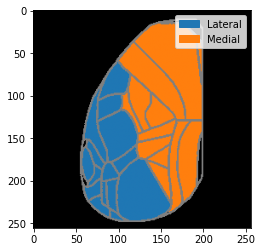

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
dataDB.plot_area_lists(ax, {'Lateral' : np.arange(15), 'Medial' : np.arange(15,27)}, haveLegend=True)

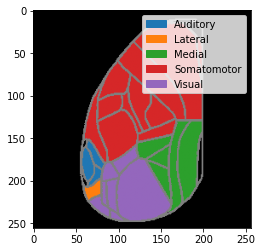

In [8]:
areas = sorted(set(dataDB.channelAreasDF['Area']))
areaDict = {a : [] for a in areas}

for iCh, chName in enumerate(dataDB.get_channel_labels()):
    rez = pd_is_one_row(pd_query(dataDB.channelAreasDF, {'LOrig' : chName}))[1]
    areaDict[rez['Area']] += [iCh]

fig, ax = plt.subplots(figsize=(4,4))
dataDB.plot_area_lists(ax, areaDict, haveLegend=True)

# 1. Significance

## 1.1. Correlation plots


## 1.2 PCA exploration

## 1.3. Highly uncorrelated channels

In [9]:
exclQueryLst = [
    {'datatype' : 'bn_trial', 'intervName' : 'PRE'},  # Baseline normalized
    {'mousename' : 'mou_6', 'intervName' : 'REW'},    # No reward for this mouse
]

In [ ]:
coactivity.plot_corr_mousephase(dataDB, mc, 'corr',
                               dataTypes=['bn_trial', 'bn_session'],
                               trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                               exclQueryLst=exclQueryLst,
                               haveMono=False)

In [ ]:
coactivity.plot_corr_mousetrialtype(dataDB, mc, 'corr',
                               dataTypes=['bn_trial', 'bn_session'],
                               trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                               exclQueryLst=exclQueryLst,
                               haveMono=False)

In [ ]:
coactivity.plot_corr_mousephase_subpre(dataDB, mc, 'corr', dropChannels=[16, 26],
                                    trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                                    exclQueryLst=exclQueryLst)

In [ ]:
coactivity.plot_corr_mousephase_submouse(dataDB, mc, 'corr', dropChannels=[16, 26],
                                         trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                                         exclQueryLst=exclQueryLst)

**Drop first PCA and explore result**

In [10]:
coactivity.plot_corr_mousephase(dataDB, mc, 'corr',
                                dataTypes=['bn_trial', 'bn_session'],
                                trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                                exclQueryLst=exclQueryLst,
                                nDropPCA=1, haveMono=False, haveBrain=True)

bn_trial_None
--skipping {'datatype': 'bn_trial', 'trialType': None, 'mousename': 'mou_5', 'intervName': 'PRE'}
0 : 0.6881964373647232 0.8329771507204551 : ['S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.6326887862816339 0.6916706473131801 : ['A1' 'AP' 'AL']
2 : 0.6132837994516253 0.7854339312096639 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
3 : 0.6396652268567344 0.7762159924873323 : ['UN' 'FL' 'M2' 'A']
4 : 0.6083079227042333 0.7573809557518983 : ['V1' 'TR' 'AM' 'PM']
5 : 0.5655331830408182 0.7451976576198923 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']
0 : 0.6355406408882688 0.7264758748170915 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6957075632879143 0.8619095675272137 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.6870811098502566 0.8852009972434643 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.6580813343248698 0.7951398790152554 : ['UN' 'M2' 'A']
4 : 0.6289666831556094 0.7495787757472363 : ['V1' 'TR' 'AM' 'PM']
5 : 0.5853129001395752 0.7474380936825724 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']
0 : 0.7057827694654271 0.747844158964544 : ['A1' 'AD' 

0 : 0.5804758759092664 0.7527752597299057 : ['A1' 'S2' 'AD' 'NO' 'BC']
1 : 0.5345706506486346 0.84625670387439 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.6121580186878159 0.7834382506462602 : ['MO' 'UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.7815032826423866 0.8798669904053273 : ['A' 'BC_2' 'BC_3']
4 : 0.684477678803007 0.778248677013737 : ['TR' 'RA' 'RD' 'BC_1']
0 : 0.5008862024087151 0.6388258709387022 : ['A1' 'S2' 'AD' 'NO' 'BC']
1 : 0.6167432870092935 0.8673228381540428 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.6195804200505609 0.8591832082514184 : ['MO' 'UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.8130513492899542 0.9773939632138671 : ['A' 'BC_2' 'BC_3']
4 : 0.5563428997504174 0.6554362889023709 : ['TR' 'RA' 'RD' 'BC_1']
0 : 0.6124431044024595 0.7577030495080783 : ['A1' 'S2' 'AD' 'NO' 'BC']
1 : 0.5559758223946955 0.8394926924089784 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.6118110797850599 0.8162350586897366 : ['MO' 'UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.6539446666963111 

/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.727007325110849 0.8551222492402353 : ['S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.5887637685277912 0.6453639364572339 : ['A1' 'AP' 'AL']
2 : 0.6019368384902216 0.8005403008469796 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
3 : 0.5053868938721955 0.6223701339220333 : ['UN' 'FL' 'M2' 'A' 'BC_3']
4 : 0.5590302716499208 0.8635600695184299 : ['V1' 'TR' 'AM' 'PM' 'RA' 'RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5568788186515455 0.6357309819459797 : ['A1' 'AD' 'AP' 'AL']
1 : 0.7035734152151526 0.8807802630590515 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.6692417984833982 0.8716505973132945 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.47541281213567443 0.6233479069527579 : ['UN' 'M2' 'A' 'BC_3']
4 : 0.7065314788047244 0.8592843800800013 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.7970977598935937 0.9015155079676984 : ['RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6627854065983291 0.835089596936363 : ['S2' 'AD' 'NO' 'BC' 'MO' 'AL' 'FL']
1 : 0.5324395424983145 0.7125032912965743 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.3758228011144323 0.49334181428504165 : ['UN' 'M2' 'A' 'BC_3']
3 : 0.6839488673222827 0.9254242253974536 : ['V1' 'TR' 'AM' 'PM' 'RA']
4 : 0.7593439018520671 0.9325091927426153 : ['RD' 'BC_1' 'BC_2']
--skipping {'datatype': 'bn_trial', 'trialType': 'Miss', 'mousename': 'mou_6', 'intervName': 'PRE'}


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.7151573649909087 1.021155958744526 : ['TEA' 'AP' 'PR' 'LI' 'PL' 'RL' 'M1']
1 : 0.40159683160080756 0.48657884302399973 : ['A1' 'AD' 'AL' 'V1']
2 : 0.6743478058705026 0.8211559726181059 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.7511480056355313 0.8129835527572256 : ['A' 'BC_3']
4 : 0.7037510409909263 0.8564655501768852 : ['UN' 'M2' 'TR' 'AM' 'PM']
5 : 0.6133619606000815 0.7213758350129644 : ['RA' 'RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.49238007672526973 0.5491402545703384 : ['A1' 'AD' 'V1']
1 : 0.6804080575482138 0.8469582129689963 : ['S2' 'NO' 'BC' 'MO' 'FL']
2 : 0.6260806067898338 0.9539845415700605 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1' 'RD']
3 : 0.4955296984895748 0.6177925767638949 : ['UN' 'A' 'BC_2' 'BC_3']
4 : 0.6461126230337585 0.8519775109129217 : ['M2' 'TR' 'AM' 'PM' 'RA' 'BC_1']
--skipping {'datatype': 'bn_trial', 'trialType': 'Miss', 'mousename': 'mou_6', 'intervName': 'REW'}
--skipping {'datatype': 'bn_trial', 'trialType': 'Miss', 'mousename': 'mou_7', 'intervName': 'PRE'}


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.46322989610142684 0.6207844640226414 : ['A1' 'TEA' 'AD' 'AP' 'AL']
1 : 0.3868729008150061 0.5584644752758856 : ['PR' 'LI' 'PL' 'RL' 'V1' 'M1']
2 : 0.6077256647783539 0.8301346460136416 : ['S2' 'NO' 'BC' 'MO' 'UN' 'FL' 'M2' 'A']
3 : 0.7152764459963957 0.8078801560691773 : ['TR' 'AM' 'PM']
4 : 0.4553673481590592 0.5822182800859544 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5824568397110069 0.6307884754165424 : ['A1' 'AD']
1 : 0.5714543364646296 0.7770703404768591 : ['S2' 'NO' 'BC' 'MO' 'FL' 'A']
2 : 0.5605850073188131 0.8320586101154022 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
3 : 0.6019333167481148 0.7821718478891866 : ['UN' 'M2' 'TR' 'AM' 'PM']
4 : 0.4717716588916477 0.5983485702863672 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5385143909993709 0.7074819039672056 : ['S2' 'AD' 'NO' 'BC' 'MO' 'FL']
1 : 0.4836002906072597 0.7306399487717765 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.5597785072752531 0.7065653764240658 : ['UN' 'A' 'BC_3']
3 : 0.6152431999442746 0.7926890030555667 : ['M2' 'TR' 'AM' 'PM']
4 : 0.5511389682011617 0.6603245560462814 : ['RA' 'RD' 'BC_1' 'BC_2']
--skipping {'datatype': 'bn_trial', 'trialType': 'Miss', 'mousename': 'mou_9', 'intervName': 'PRE'}
0 : 0.4371617174316359 0.6156824206685153 : ['A1' 'S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.6282651819815567 0.9334429306329856 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.6507476096934787 0.8234112112967906 : ['UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.6978518400103492 0.8217916091064335 : ['A' 'BC_2' 'BC_3']
4 : 0.6855290543305886 0.7854437957404651 : ['TR' 'RA' 'RD' 'BC_1']
0 : 0.6039289289469463 0.89408174729885 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
1 : 0.5028548483886529 0.7063822058537967 : ['S2' 'AD' 'NO' 'BC

/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6510634361480374 0.7344948906757884 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6749424175763142 0.8414920988935429 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.7133663156188438 0.8600744059051791 : ['S2' 'NO' 'BC' 'MO']
3 : 0.7338325190819227 0.9165109750508764 : ['UN' 'FL' 'M2' 'A']
4 : 0.5862997814046319 0.7243723058635452 : ['V1' 'TR' 'AM' 'PM']
5 : 0.5182547146601525 0.6644297122973122 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.4477322899789714 0.5282437862256486 : ['A1' 'AD' 'AP' 'AL' 'V1']
1 : 0.7108640056844132 0.8777781176368642 : ['S2' 'NO' 'BC' 'MO' 'FL']
2 : 0.7366519230976897 0.9108941883729856 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
3 : 0.476770757868994 0.6160972838073411 : ['UN' 'M2' 'A' 'BC_3']
4 : 0.8334777770911584 0.9935618142449396 : ['TR' 'AM' 'PM']
5 : 0.6868503476255009 0.8516191789893982 : ['RA' 'RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.67510427831827 0.7226643058867878 : ['A1' 'AD' 'AP' 'AL']
1 : 0.7041371140302313 0.8405823029277537 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.4999845729851666 0.6676819942357717 : ['S2' 'NO' 'BC' 'MO' 'FL' 'A']
3 : 0.5493411636735092 0.8336366971902593 : ['V1' 'UN' 'M2' 'TR' 'AM' 'PM' 'RA']
4 : 0.5072280612038619 0.636693117590146 : ['RD' 'BC_1' 'BC_2' 'BC_3']
--skipping {'datatype': 'bn_trial', 'trialType': 'FA', 'mousename': 'mou_6', 'intervName': 'PRE'}


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.7787330152127095 1.0582388284075712 : ['TEA' 'AP' 'PR' 'LI' 'PL' 'RL' 'M1']
1 : 0.39808152555370213 0.5121685783183754 : ['A1' 'S2' 'AD' 'AL' 'V1']
2 : 0.6578891644932398 0.795728915388109 : ['NO' 'BC' 'MO' 'FL']
3 : 0.8205316641946004 0.8887218606957982 : ['A' 'BC_3']
4 : 0.7549481937413827 0.9485792430678477 : ['UN' 'M2' 'TR' 'AM' 'PM']
5 : 0.5697138020514564 0.6681241661516524 : ['RA' 'RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.403676957091766 0.4866364776917421 : ['A1' 'AD' 'AP' 'V1']
1 : 0.6400344629136562 0.7562494764399392 : ['S2' 'NO' 'BC' 'MO']
2 : 0.6075160158925067 0.8987603365105177 : ['TEA' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1' 'RD']
3 : 0.6028678331282165 0.7295931403324334 : ['UN' 'A' 'BC_2' 'BC_3']
4 : 0.6149288632261122 0.840533627799518 : ['FL' 'M2' 'TR' 'AM' 'PM' 'RA' 'BC_1']
--skipping {'datatype': 'bn_trial', 'trialType': 'FA', 'mousename': 'mou_6', 'intervName': 'REW'}
--skipping {'datatype': 'bn_trial', 'trialType': 'FA', 'mousename': 'mou_7', 'intervName': 'PRE'}
0 : 0.3727213587017307 0.6369318860485678 : ['A1' 'TEA' 'AD' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
1 : 0.5674268378356493 0.7706453841944084 : ['S2' 'NO' 'BC' 'MO' 'FL' 'A' 'BC_3']
2 : 0.5679571463646125 0.7605597268516766 : ['UN' 'M2' 'TR' 'AM' 'PM']
3 : 0.6622159920634726 0.8048775561208162 : ['RA' 'RD' 'BC_1' 'BC_2']
0 : 0.5402627307911014 0.7095160369457256 : ['S2' 'AD' 'NO' 'BC' 'FL']
1 : 0.5215011207422379 0.78026763396837

bn_session_Hit
0 : 0.6786101798036003 0.7591964274950194 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6593246192503546 0.8252829676500613 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.7140171265664138 0.8716860249138597 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.5896063318231204 0.7007695067037009 : ['UN' 'M2' 'A']
4 : 0.6135940219565398 0.744882842026704 : ['V1' 'TR' 'AM' 'PM']
5 : 0.5938636751484471 0.8032416768524941 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']
0 : 0.6931226847712894 0.774714081591013 : ['A1' 'AD' 'AP' 'AL']
1 : 0.7362368247187477 0.8540946034778518 : ['TEA' 'PR' 'LI' 'PL' 'RL']
2 : 0.7299835972871312 0.8946514106682996 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.5624303203831104 0.6867519229808251 : ['UN' 'M2' 'A']
4 : 0.6188985391599825 0.8090001787862829 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.544721519771738 0.7224050263188779 : ['M1' 'RD' 'BC_1' 'BC_2' 'BC_3']
0 : 0.6637973415619872 0.7469130519001859 : ['A1' 'AD' 'AP' 'AL']
1 : 0.7120171132630941 0.8832361914777798 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.57599

0 : 0.5877925118545414 0.7692442401527502 : ['S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.5474464848377033 0.7967042096669562 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.6118758616927468 0.8609354816814088 : ['UN' 'FL' 'M2' 'TR' 'AM' 'PM']
3 : 0.7759107249678432 0.91105100811693 : ['A' 'BC_3']
4 : 0.6014721103155153 0.6967855193532138 : ['RA' 'RD' 'BC_1' 'BC_2']
0 : 0.46492670291373517 0.70654390035166 : ['A1' 'TEA' 'AD' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
1 : 0.7050868067545608 0.9360984633814103 : ['S2' 'NO' 'BC' 'MO' 'FL']
2 : 0.7717228802212719 0.9048675382510224 : ['A' 'BC_3']
3 : 0.6764054108922977 0.9017552334132404 : ['UN' 'M2' 'TR' 'AM' 'PM']
4 : 0.6649526489904299 0.7590106748543886 : ['RA' 'RD' 'BC_1' 'BC_2']
0 : 0.503197992612325 0.7803244691332821 : ['A1' 'TEA' 'AD' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
1 : 0.7174318790966567 0.8773839455688321 : ['S2' 'NO' 'BC' 'MO']
2 : 0.6753148297214574 0.9217488626375007 : ['UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.7440765485868814 

/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5889307027769465 0.6325213823406802 : ['A1' 'AP' 'AL']
1 : 0.6957696238445902 0.8822112472400493 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.7155882690421925 0.9295531734501604 : ['S2' 'AD' 'NO' 'BC' 'MO' 'FL']
3 : 0.49259675126740937 0.626486033048274 : ['UN' 'M2' 'A' 'BC_3']
4 : 0.5876504246634298 0.872419859350112 : ['V1' 'TR' 'AM' 'PM' 'RA' 'RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.7238066309839878 0.8866315441481896 : ['S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.5735925521378885 0.6195360080050589 : ['A1' 'AP' 'AL']
2 : 0.6245685163078415 0.8023417369963382 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
3 : 0.6225591859673795 0.7584337523063507 : ['UN' 'FL' 'M2' 'A']
4 : 0.7350706955047789 0.9277022405773735 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.539651070982514 0.6816449839605421 : ['RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.60640399099165 0.6700780127811021 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6872160524773105 0.8699328957330119 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.5884172770020933 0.7010328498137455 : ['S2' 'NO' 'BC' 'MO']
3 : 0.598399751339089 0.7470195528098184 : ['UN' 'FL' 'M2' 'A']
4 : 0.6397868996226419 0.8061025607892346 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.564291562607279 0.7161103681262015 : ['RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6682815616507914 0.7076621837748248 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6588670919708156 0.7894207569484322 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.7639920385437202 0.881255134001127 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.6011544523779271 0.7331712306053554 : ['UN' 'M2' 'A']
4 : 0.6428319923015939 0.8772266345655708 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.45505322325525527 0.6268723105282125 : ['RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6493326903484921 0.963785005996671 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1']
1 : 0.5226172525452469 0.7172508845075078 : ['S2' 'AD' 'NO' 'BC' 'MO' 'V1' 'FL']
2 : 0.6951926400136178 0.9290179119613811 : ['UN' 'M2' 'TR' 'AM' 'PM' 'RA']
3 : 0.41486468388883163 0.558391004813916 : ['A' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5998406998072726 0.9461879948817016 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1']
1 : 0.49625486232865557 0.6761883915401504 : ['S2' 'AD' 'NO' 'BC' 'MO' 'V1' 'FL']
2 : 0.8463883089923747 0.926186408725478 : ['A' 'BC_3']
3 : 0.7349005210748126 0.899112576864608 : ['UN' 'M2' 'TR' 'AM' 'PM']
4 : 0.5644936554120368 0.6639652934633913 : ['RA' 'RD' 'BC_1' 'BC_2']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6030864108631818 0.92884870505123 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1' 'RD']
1 : 0.5000661903225946 0.676214807289925 : ['S2' 'AD' 'NO' 'BC' 'MO' 'V1' 'FL']
2 : 0.6035793120030811 0.7176434215954612 : ['A' 'BC_2' 'BC_3']
3 : 0.6456588152015338 0.945342169459884 : ['UN' 'M2' 'TR' 'AM' 'PM' 'RA' 'BC_1']
--skipping {'datatype': 'bn_session', 'trialType': 'Miss', 'mousename': 'mou_6', 'intervName': 'REW'}


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5904020954194269 0.7518162241449446 : ['S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.4737677937422511 0.7562208424108703 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.5277678530767981 0.7558554165676078 : ['UN' 'FL' 'M2' 'A' 'TR' 'AM' 'PM']
3 : 0.4260214408374722 0.543013882469986 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.42839000135773414 0.4864494002115267 : ['A1' 'AD' 'V1']
1 : 0.5904771998633824 0.8539997685494283 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1']
2 : 0.7401398041919326 0.932944292947381 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.6559331762070676 0.8400161650098014 : ['UN' 'M2' 'A' 'AM' 'PM']
4 : 0.3560566277481036 0.47222355770585117 : ['TR' 'RA' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.467781362101503 0.5465120764208344 : ['A1' 'AD' 'AP' 'AL' 'V1']
1 : 0.5247624778481793 0.711167993577298 : ['S2' 'NO' 'BC' 'MO' 'FL' 'A']
2 : 0.7216052864421088 0.8928976422275461 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
3 : 0.6428339608680294 0.8526357384965368 : ['UN' 'M2' 'TR' 'AM' 'PM']
4 : 0.5120410734909496 0.6660793672621429 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5492530186214848 0.7556154586849303 : ['A1' 'TEA' 'AD' 'AP' 'PR' 'LI' 'AL' 'PL']
1 : 0.554691699634715 0.750479911378238 : ['S2' 'NO' 'BC' 'MO' 'FL' 'A']
2 : 0.3710738409993255 0.3982667377610656 : ['RL' 'V1' 'M1']
3 : 0.5866280062205002 0.7909867720459683 : ['UN' 'M2' 'TR' 'AM' 'PM']
4 : 0.4398543554913014 0.5630549683795179 : ['RA' 'RD' 'BC_1' 'BC_2' 'BC_3']
0 : 0.48831278450997756 0.6301593342962963 : ['A1' 'S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.5865156426453719 0.8925735778648692 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.6872632906642719 0.871497838517618 : ['UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.6348529874479275 0.7367313320263111 : ['A' 'BC_2' 'BC_3']
4 : 0.701438744785056 0.8513485090381675 : ['TR' 'RA' 'RD' 'BC_1']
0 : 0.5590303766657685 0.7261484075784047 : ['A1' 'S2' 'AD' 'NO' 'BC']
1 : 0.6517013193765896 0.9335259776358529 : ['TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.5773494415329967 0.803777923090853 : ['MO' 'UN' 'FL' 'M2' 'AM' 'PM']
3 : 0.6552107786391758 

/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5996561141712738 0.6670537301024595 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6731730792147598 0.8416060803542763 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.569370962723016 0.7160958202370713 : ['S2' 'NO' 'BC' 'MO' 'A']
3 : 0.7503553117263614 0.8675168388025336 : ['UN' 'FL' 'M2']
4 : 0.691286736943853 0.8837799883778987 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.4757151102822014 0.6230893155516981 : ['RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6414425547572035 0.8003914406505817 : ['S2' 'AD' 'NO' 'BC' 'MO']
1 : 0.6014769902865759 0.7840663241357222 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL']
2 : 0.7410190080693919 0.8956854657665808 : ['UN' 'FL' 'M2']
3 : 0.6788377222007113 0.83229882134088 : ['V1' 'TR' 'AM' 'PM']
4 : 0.6772129846534848 0.8060941654717697 : ['M1' 'RA' 'RD' 'BC_1']
5 : 0.5238254347043186 0.6550294862201967 : ['A' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.6610874400424801 0.721923901245361 : ['A1' 'AD' 'AP' 'AL']
1 : 0.6981549123636845 0.8414645571225744 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.6620194062855803 0.7767441041059906 : ['S2' 'NO' 'BC' 'MO']
3 : 0.6805932344143463 0.8090271470310724 : ['UN' 'FL' 'M2']
4 : 0.6054563324452438 0.7945380798861219 : ['V1' 'TR' 'AM' 'PM' 'RA']
5 : 0.5273827558179556 0.7211499778810543 : ['A' 'RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.7010337562386573 0.7330959475302226 : ['A1' 'AD' 'AP' 'AL']
1 : 0.7396781561511764 0.876209386531742 : ['TEA' 'PR' 'LI' 'PL' 'RL' 'M1']
2 : 0.5537527221036647 0.6564790862467134 : ['S2' 'NO' 'BC' 'MO' 'FL']
3 : 0.495127160604489 0.8172971978119565 : ['V1' 'UN' 'M2' 'A' 'TR' 'AM' 'PM' 'RA']
4 : 0.5998231185246796 0.7604180343576478 : ['RD' 'BC_1' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.690504422357561 0.9908972027015968 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1']
1 : 0.43710983554351335 0.594396537491585 : ['S2' 'AD' 'NO' 'BC' 'V1' 'FL']
2 : 0.38985534789991594 0.5637562558720224 : ['MO' 'UN' 'A' 'BC_2' 'BC_3']
3 : 0.5446479042640308 0.751582380928503 : ['M2' 'TR' 'AM' 'PM' 'RA' 'RD' 'BC_1']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.5855969527869945 0.9102323355663156 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1' 'RD']
1 : 0.5246251969258651 0.7209610293365856 : ['S2' 'AD' 'NO' 'BC' 'MO' 'FL']
2 : 0.6176690711707012 0.9186532197351551 : ['UN' 'M2' 'TR' 'AM' 'PM' 'RA' 'BC_1']
3 : 0.505595118799809 0.5930038184511419 : ['A' 'BC_2' 'BC_3']


/home/alyosha/work/mesostat-dev/mesostat/utils/signals/filter.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x, axis=axis).reshape(shapeNew)
/home/alyosha/.conda/envs/py38idtxl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 : 0.4665176185089392 0.6167055285051165 : ['S2' 'AD' 'NO' 'BC' 'MO' 'V1']
1 : 0.5201511799915965 0.8373409713172462 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'M1' 'RD']
2 : 0.5980184452004408 0.6947392558723797 : ['A' 'BC_2' 'BC_3']
3 : 0.614595653480899 0.9115222256998481 : ['UN' 'FL' 'M2' 'TR' 'AM' 'PM' 'RA' 'BC_1']
--skipping {'datatype': 'bn_session', 'trialType': 'FA', 'mousename': 'mou_6', 'intervName': 'REW'}
0 : 0.5395664949235746 0.7551564403906601 : ['S2' 'AD' 'NO' 'BC' 'MO' 'FL']
1 : 0.5213991223073541 0.7716662610855705 : ['A1' 'TEA' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
2 : 0.46268550350428467 0.5921135959778864 : ['UN' 'A' 'BC_3']
3 : 0.6755042117359085 0.8502353077966689 : ['M2' 'TR' 'AM' 'PM']
4 : 0.6152546394147521 0.7152188850137648 : ['RA' 'RD' 'BC_1' 'BC_2']
0 : 0.4423628037126296 0.7003416147788082 : ['A1' 'TEA' 'AD' 'AP' 'PR' 'LI' 'AL' 'PL' 'RL' 'V1' 'M1']
1 : 0.5079605000242212 0.7553087109002392 : ['S2' 'NO' 'BC' 'MO' 'FL' 'A' 'BC_3']
2 : 0.61700785761561

In [ ]:
coactivity.plot_corr_mousetrialtype(dataDB, mc, 'corr',
                                    dataTypes=['bn_trial', 'bn_session'],
                                    trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                                    exclQueryLst=exclQueryLst,
                                    nDropPCA=1, haveMono=False)

In [ ]:
coactivity.plot_corr_mousephase_subpre(dataDB, mc, 'corr', dropChannels=[16, 26],
                                       trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                                       nDropPCA=1,
                                       exclQueryLst=exclQueryLst)

In [ ]:
coactivity.plot_corr_mousephase_submouse(dataDB, mc, 'corr', dropChannels=[16, 26],
                                         trialTypes=['None', 'Hit', 'CR', 'Miss', 'FA'],
                                         nDropPCA=1,
                                         exclQueryLst=exclQueryLst)

# 2. Consistency
## 2.1. PCA consistency over mice
### 2.1.1. Angle-based consistency

Tasks
  * Explained variance by phase/session/mouse/trialType
     * Do not separate phases, its meaningless. Compute PCA for all timesteps, then see proj differences for phases
     * Implement HAC correction

  * Global PCA shifts vs session

Approaches:
  * Eval PCA over all data, select strongest components, plot components as function of cofound
  * Eval PCA for cofounds, compare PCA
  
**Plots**:
* Cosine-squared matrix $C^2_{ij} = (R^{1}_{ik}R^{2}_{jk})^2$, where $R^l$ is the PCA-transform
* Consistency metric $E = e^1_i e^2_j C^2_{ij}$, where $e^l$ are the eigenvalues

**Problem**:
The consistency metric $E$ has all necessary ingredients (angles, eigenvalues), but it is not mathematically clear that it behaves the desired way. Solid theory is required for this metric to be useful.

**Alternative approach**:
Try consistency metric $H(\frac{C^2_{ij}}{N})$. Should be great at measuring the sparsity of basis coupling. The challenge is to include eigenvalue priority into this metric, since spread of weak eigenvalues is not as relevant as spread of strong ones.

In [ ]:
for datatype in ['bn_session', 'bn_trial']:
    coactivity.plot_pca_alignment_bymouse(dataDB, datatype=datatype, trialType=None, intervName='DEL')

### 2.1.2. Eigenvalue-based consistency

* Let $x_1$, $x_2$ be some datasets
* Let $R_1$, $R_2$ be the corresponding PCA-transforms 
* Find total variances
    - $V_1 = \sum_i eig_i(x_1) = tr(cov(x_1)) = \sum_i cov_{ii}(x_1)$
    - $V_2 = \sum_i eig_i(x_2) = tr(cov(x_2)) = \sum_i cov_{ii}(x_2)$
* Find explained variances
    - $e_1 = eval(cov(x_1)) = diag(cov(R_1 x_1))$
    - $e_2 = eval(cov(x_2)) = diag(cov(R_2 x_2))$
* Find explained variances using wrong bases
    - $e_{12} = diag(cov(R_2 x_1))$
    - $e_{21} = diag(cov(R_1 x_2))$
* Find representation errors in explained variance ratios
    - $\epsilon_1 = \frac{\sum_i |e^1_i - e^{12}_i|}{2 V_1}$
    - $\epsilon_2 = \frac{\sum_i |e^2_i - e^{21}_i|}{2 V_2}$



* TODO: iter trialType=[hit, cr, all]
* TODO: iter perf=[naive,expert,all]

In [ ]:
coactivity.plot_corr_consistency_l1(dataDB, intervDict)#, dropChannels=[26])

In [ ]:
coactivity.plot_corr_consistency_l1(dataDB, intervDict, nDropPCA=1)#, dropChannels=[26])

In [ ]:
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, trialTypes=['Hit', 'CR'], datatype='bn_trial')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, trialTypes=['Hit', 'CR'], datatype='bn_session')

In [ ]:
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, nDropPCA=1, trialTypes=['Hit', 'CR'], datatype='bn_trial')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, nDropPCA=1, trialTypes=['Hit', 'CR'], datatype='bn_session')

In [ ]:
intervDictNoPre = intervDict.copy()
del intervDictNoPre['PRE']

In [ ]:
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, datatype='bn_trial')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, datatype='bn_session')

In [ ]:
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, nDropPCA=1, datatype='bn_trial')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, nDropPCA=1, datatype='bn_session')

## 2.2. PCA consistency over phases
### 2.2.1 Angle-based consistency

In [ ]:
for datatype in ['bn_session', 'bn_trial']:
    coactivity.plot_pca_alignment_byphase(dataDB, intervNames=['TEX', 'REW'], datatype=datatype, trialType=None)